**Information**

The information gathered is from the DAEWOO Steel Co. Ltd in Gwangyang, South Korea. It produces several types of coils, steel plates, and iron plates.<br> The information on electricity consumption is held in a cloud-based system.<br><br> The information on energy consumption of the industry is stored on the website of the Korea Electric Power Corporation (pccs.kepco.go.kr),<br> and the perspectives on daily, monthly, and annual data are calculated and shown.<br><br>
Source: https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors


In [3]:
df = pd.read_csv("datasets/Steel_industry_data.csv")
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [4]:
df.shape 

(35040, 11)

In [5]:
# Check duplicate rows
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [7]:
# date column is not in datetime format, first task is to convert it to datetime format.
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')
df = df.sort_values('date').reset_index(drop=True)
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load
1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
3,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load


In [8]:
# the data is recorded at 15 min intervals. 

# Let's find the time range of the data
print("Start date:",df['date'].min())
print("End date:",df['date'].max())
# that is around 1 year of data. 

Start date: 2018-01-01 00:00:00
End date: 2018-12-31 23:45:00


In [9]:
# Load type is categorical and weekstatus are, let's check the unique values and their counts.
print(df['Load_Type'].value_counts())
# the classses are imbalanced
# This column has to be correlated with usage of energy column. 

Load_Type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64


In [10]:
# let's check how does the usage of energy change across load types and week status?
# making a group summary of usage of energt  by load and weekstatus of 95% 

Summary =(df.groupby(["Load_Type","WeekStatus"])["Usage_kWh"].agg(n="size", mean="mean", median="median",
           p95=lambda s:s.quantile(0.95)).round(1))
Summary.sort_index()
# light load is skewed, median is 3.4 and 95 is 62, most of the time, usage is low. But sometimes the usage of energy is too high. 
# As I exptected, during weekdays the usage of energy is too high.

n  mean  median    p95
Load_Type    WeekStatus                            
Light_Load   Weekday     11168  10.6     3.4   62.0
             Weekend      6904   5.4     3.2    6.6
Maximum_Load Weekday      5952  64.0    59.3  115.1
             Weekend      1320  37.7    34.3   94.9
Medium_Load  Weekday      7936  43.2    42.4  109.6
             Weekend      1760  17.2     4.0   71.3

In [11]:
# so let's find the peak hours, I should be during the day. 
# Grouping
grouping_per_hour = (df.assign(hour=df["date"].dt.hour)
                    .groupby(["Load_Type","WeekStatus","hour"])["Usage_kWh"].median().reset_index(name="median_kWh"))

peak = grouping_per_hour.loc[grouping_per_hour.groupby(["Load_Type","WeekStatus"])["median_kWh"].idxmax()].sort_values(["Load_Type","WeekStatus"])
peak["median_kWh"]= peak["median_kWh"].round(1)
peak
# All the peak hours are during the days.

,Load_Type,WeekStatus,hour,median_kWh
9,Light_Load,Weekday,9,63.2
32,Light_Load,Weekend,8,4.1
49,Maximum_Load,Weekday,11,64.6
61,Maximum_Load,Weekend,10,40.6
78,Medium_Load,Weekday,14,72.6
92,Medium_Load,Weekend,14,48.1


In [12]:
# Now, let's computing kurtosis for each continous colums by using scipy 
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
desc = df[numeric_columns].describe().T                          
desc['skew'] = df[numeric_columns].apply(stats.skew)            
desc['kurtosis'] = df[numeric_columns].apply(stats.kurtosis)     
desc.round(2)
# the usage of enetgy has right skewed. 
# Leading_Current_Reactive_Power_kVarh has high kurtosis and right skewed.
# Overall that is a bad ds, this kind of dstribution is normal for energy consumption DS.

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Usage_kWh,35040.0,27.39,33.44,0.0,3.20,4.57,51.24,157.18,1.20,0.39
Lagging_Current_Reactive.Power_kVarh,35040.0,13.04,16.31,0.0,2.30,5.00,22.64,96.91,1.44,1.21
Leading_Current_Reactive_Power_kVarh,35040.0,3.87,7.42,0.0,0.00,0.00,2.09,27.76,1.73,1.58
CO2(tCO2),35040.0,0.01,0.02,0.0,0.00,0.00,0.02,0.07,1.15,0.21
Lagging_Current_Power_Factor,35040.0,80.58,18.92,0.0,63.32,87.96,99.02,100.00,-0.61,-1.10
Leading_Current_Power_Factor,35040.0,84.37,30.46,0.0,99.70,100.00,100.00,100.00,-1.51,0.38
NSM,35040.0,42750.00,24940.53,0.0,21375.00,42750.00,64125.00,85500.00,0.00,-1.20


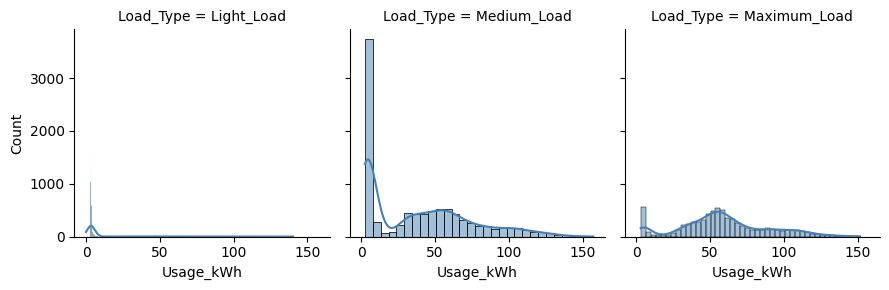

In [13]:
# Making separate subplot for each load type classes
grid_object = sns.FacetGrid(df, col="Load_Type", col_order=["Light_Load", "Medium_Load", "Maximum_Load"])
grid_object.map_dataframe(sns.histplot, x="Usage_kWh",kde=True, color="steelblue")
plt.show()
# Generally maximum load has normal distribution 

In [14]:
# Comverting the catergorical:
categorical_columns=["WeekStatus", "Load_Type"]
df = pd.get_dummies(df, columns=[column for column in categorical_columns], dtype = 'int')
df

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,WeekStatus_Weekday,WeekStatus_Weekend,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,2018-01-01 00:00:00,3.42,3.46,0.00,0.0,70.30,100.00,0,Monday,1,0,1,0,0
1,2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,Monday,1,0,1,0,0
2,2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,Monday,1,0,1,0,0
3,2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,Monday,1,0,1,0,0
4,2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Monday,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 22:45:00,3.82,4.54,0.00,0.0,64.38,100.00,81900,Monday,1,0,1,0,0
35036,2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Monday,1,0,1,0,0
35037,2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,Monday,1,0,1,0,0
35038,2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,Monday,1,0,1,0,0


In [15]:
# Extractinh hour and month 
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month
df = df.drop(columns=['date', 'NSM', 'Day_of_week'])

In [16]:
correlation = df.corr(method="spearman")
corr_energy = correlation["Usage_kWh"].drop("Usage_kWh")
print("Usage_kWh:\n", corr_energy.round(3).sort_values(ascending=False))

# CO2 gas has strong correlation with usage of energy.
# Weekend has negative correlation with usage of energy.

Usage_kWh:
 CO2(tCO2)                               0.882
Lagging_Current_Reactive.Power_kVarh    0.645
Load_Type_Maximum_Load                  0.499
Lagging_Current_Power_Factor            0.375
hour                                    0.322
WeekStatus_Weekday                      0.314
Load_Type_Medium_Load                   0.306
Leading_Current_Power_Factor            0.194
Leading_Current_Reactive_Power_kVarh   -0.132
month                                  -0.156
WeekStatus_Weekend                     -0.314
Load_Type_Light_Load                   -0.679
Name: Usage_kWh, dtype: float64


In [17]:
# In previous  cell, Usage of energy is skewed, let's find the consistant uage of energy by month and hour.
# Creating pivot table for usage of energy by month and hour, using median to find the consistant usage of energy.
heat = df.pivot_table(values="Usage_kWh", index="month", columns="hour", aggfunc="median")
top = heat.stack().sort_values(ascending=False).head(10).round(1)
print(" Top month and hour by median Usage_kWh:\n", top)

# As previous cell, the peak hours are working hours and the peak months are during the winter.

 Top month and hour by median Usage_kWh:
 month  hour
1      16      80.1
       14      80.0
       11      78.5
       15      77.6
       9       76.9
       10      74.4
       17      67.9
11     9       67.4
2      11      65.0
3      9       64.8
dtype: float64


### Multicollinearity 

In [18]:
list_columns = ['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)',
            'Lagging_Current_Power_Factor','Leading_Current_Power_Factor','hour','month']

X = df[list_columns]
vif_data= pd.DataFrame({'Feature': list_columns,'VIF':[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]})
vif_data= vif_data.sort_values('VIF', ascending=False)
print("VIF Analysis\n")
print(vif_data.round(1).to_string(index=False))


VIF Analysis

                             Feature  VIF
        Lagging_Current_Power_Factor 39.3
        Leading_Current_Power_Factor 19.9
                           CO2(tCO2) 10.6
Lagging_Current_Reactive.Power_kVarh  9.0
Leading_Current_Reactive_Power_kVarh  7.7
                                hour  5.8
                               month  4.6


In [19]:
# Droping redundant columns is the easy way. 
# I am going to combine the Lagging reactive with leading reactive.
# lagging and leading are reactive energy columns


# Lagging reactive usually comes from motors and transformers.  
# Leading reactive  comes from capacitor correction

# I can combine them:
# reactive total = lagging + leading which means how much reactive energy exists overall
# To understand this concept, how these columns are related to each other, I used QwEN 3MAX 
df["reactive_total"] = df["Lagging_Current_Reactive.Power_kVarh"] + df["Leading_Current_Reactive_Power_kVarh"]
df = df.drop(['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)'], axis=1)

In [20]:
df.shape

(35040, 11)

### Outliers

In [ ]:
# Detecting outliers by using IQR and Isolation Forest

# Computing 25 and 75 % usage of energy
Q1 = df['Usage_kWh'].quantile(0.25)
Q3 = df['Usage_kWh'].quantile(0.75)
IQR = Q3 - Q1

iqr_outliers = (df['Usage_kWh'] < Q1-1.5*IQR) | (df['Usage_kWh'] > Q3+1.5*IQR)


continues_columns = ['Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
                    'reactive_total', 'hour', 'month']

isolation_forest = IsolationForest(contamination='auto', random_state=42).fit_predict(df[continues_columns])==-1
# For debugging, I used QWEN 3MAX

In [31]:
print(f"IQR outliers:{iqr_outliers.sum()}")
print(f"Isolation forest outliers:{isolation_forest.sum()}")
print(f"Both flagged:{(iqr_outliers & isolation_forest).sum()}")

IQR outliers:328
Isolation forest outliers:13436
Both flagged:285


In [26]:
df = df.loc[~(iqr_outliers & isolation_forest)]
df.shape

(34755, 11)

### Noise management

In [ ]:
y = df["Usage_kWh"]
X = df.drop(columns=["Usage_kWh"])
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2:{r2_score(y_test, y_pred):.3f}")
print(f"MAE:{mean_absolute_error(y_test, y_pred):.3f}")
print(f"RMSE:{np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# RMSE is almost one KHW, so that is not bad. 

R2:0.999
MAE:0.322
RMSE:1.034


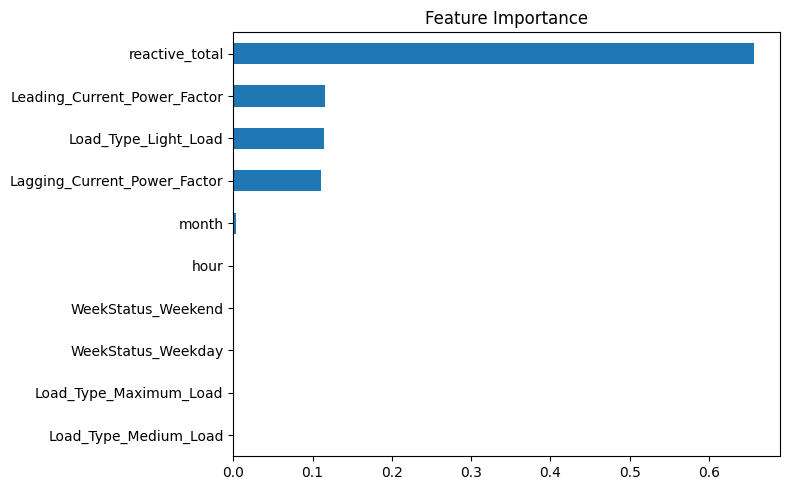

In [37]:
# feature importance
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=True).plot.barh(figsize=(8, 5))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()